In [28]:
import os
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

import gensim.downloader as api

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, DataLoader, random_split)
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Loading word2vec model**

In [2]:
embed_lookup = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


# **Class Distribution Visualization**

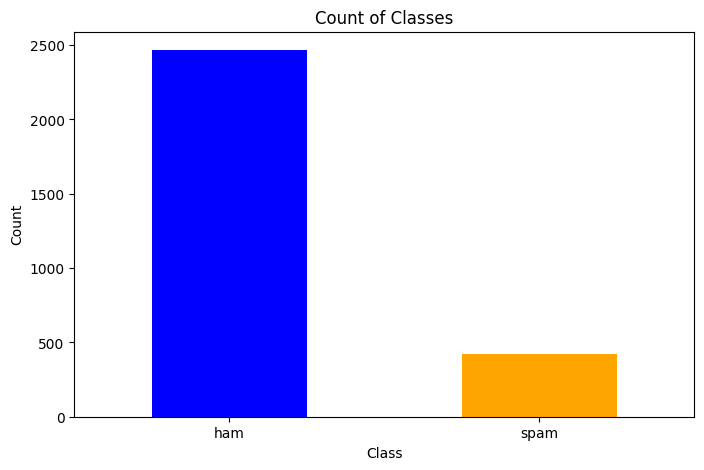

In [31]:
df = pd.read_csv("/kaggle/input/test-task-data-1/test.csv")
class_counts = df['label'].value_counts()

plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Count of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# **Custom Dataset Class for Text Processing**

In [3]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file_path, embed_lookup, transform=None, target_transform=None):
        self.df = pd.read_csv(annotations_file_path)
        self.df = self.df.dropna()
        self.map_dict = {"spam":1, "ham":0}
        self.df["label"] = self.df["label"].map(self.map_dict)
        self.transform = transform
        self.target_transform = target_transform
        self.embed_lookup = embed_lookup
        self.preprocess_column()
        self.tokenize_all_text()
        self.pad_features()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df["label"].iloc[idx]
        image = self.df["array_data"].iloc[idx]
        image = torch.tensor(image, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)  
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
    def preprocess_column(self, column_name='email'):
        """Apply decode, lowercase, strip, stemming, stop word removal, and punctuation removal to a specified column,
        and save the processed words as lists in the DataFrame."""
        # Initialize the stemmer and stop words
        stemmer = PorterStemmer()
        stop_words = set(stopwords.words('english'))

        def process_text(text):
            if isinstance(text, str):
                # Lowercase and strip
                text = text.lower().strip()
                # Remove digits
                text = re.sub(r'\d+', '', text)
                # Remove punctuation
                text = text.translate(str.maketrans('', '', string.punctuation))
                # Split into words, remove stop words, and apply stemming
                words = text.split()
                words = [stemmer.stem(word) for word in words if word not in stop_words]
                return words
            return text

        # Apply the processing function and store lists of words in the specified column
        self.df[column_name] = self.df[column_name].apply(process_text)
    
    def tokenize_all_text(self):
        text = self.df['email']
        tokenized_text = []
        tokenized_reviews = []
        for review in text:
            ints = []
            for word in review:
                try:
                    idx = self.embed_lookup.key_to_index[word]
                except KeyError:
                    idx = 0
                ints.append(idx)
            if any(ints):
                tokenized_reviews.append(ints)
            else:
                tokenized_reviews.append([])
        self.df.loc[:, "tokenized_email"] = tokenized_reviews
        self.df = self.df[self.df["tokenized_email"].apply(lambda x: any(x))]

    def pad_features(self, seq_length=300):
        ''' Return features of tokenized_reviews, where each review is padded with 0's
            or truncated to the input seq_length.
        '''
        tokenized_reviews = self.df["tokenized_email"]
        features = np.zeros((len(tokenized_reviews), seq_length), dtype=int)

        for i, row in enumerate(tokenized_reviews):
            if len(row) > 0:
                features[i, -len(row):] = np.array(row)[:seq_length]
                
        self.df["array_data"] = [list(feature_row) for feature_row in features]


# **Load data**

In [4]:
train_dataset = CustomDataset("/kaggle/input/test-task-data-1/train.csv", embed_lookup)
test_dataset = CustomDataset("/kaggle/input/test-task-data-1/test.csv", embed_lookup)

In [5]:
total_size = len(train_dataset)
train_size = int(0.8 * total_size) 
val_size = total_size - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [6]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

# **Sentiment Analysis CNN Model**

In [8]:
class SentimentCNN(nn.Module):
    """
    The embedding layer + CNN model that will be used to perform sentiment analysis.
    """

    def __init__(self, embed_model, vocab_size, output_size, embedding_dim,
                 num_filters=100, kernel_sizes=[3, 4, 5], freeze_embeddings=True, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentCNN, self).__init__()

        # set class vars
        self.num_filters = num_filters
        self.embedding_dim = embedding_dim
        
        # 1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # set weights to pre-trained
        self.embedding.weight = nn.Parameter(torch.from_numpy(embed_model.vectors)) # all vectors
        # (optional) freeze embedding weights
        if freeze_embeddings:
            self.embedding.requires_grad = False
        
        # 2. convolutional layers
        self.convs_1d = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim), padding=(k-2,0)) 
            for k in kernel_sizes])
        
        # 3. final, fully-connected layer for classification
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_size) 
        
        # 4. dropout and sigmoid layers
        self.dropout = nn.Dropout(drop_prob)
        self.sig = nn.Sigmoid()
        
    
    def conv_and_pool(self, x, conv):
        """
        Convolutional + max pooling layer
        """
        # squeeze last dim to get size: (batch_size, num_filters, conv_seq_length)
        # conv_seq_length will be ~ 200
        x = F.relu(conv(x)).squeeze(3)
        
        # 1D pool over conv_seq_length
        # squeeze to get size: (batch_size, num_filters)
        x_max = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x_max

    def forward(self, x):
        """
        Defines how a batch of inputs, x, passes through the model layers.
        Returns a single, sigmoid-activated class score as output.
        """
        # embedded vectors
        embeds = self.embedding(x) # (batch_size, seq_length, embedding_dim)
        embeds = embeds.unsqueeze(1)
        conv_results = [self.conv_and_pool(embeds, conv) for conv in self.convs_1d]
        
        x = torch.cat(conv_results, 1)
        x = self.dropout(x)
        
        # final logit
        logit = self.fc(x) 
        
        # sigmoid-activated --> a class score
        return self.sig(logit)

In [9]:
pretrained_words = list(embed_lookup.key_to_index.keys())

In [20]:
vocab_size = len(pretrained_words)
output_size = 1 # binary class (1 or 0)
embedding_dim = len(embed_lookup[pretrained_words[0]])
num_filters = 100
kernel_sizes = [3, 4, 5]

net = SentimentCNN(embed_lookup, vocab_size, output_size, embedding_dim,
                   num_filters, kernel_sizes)

!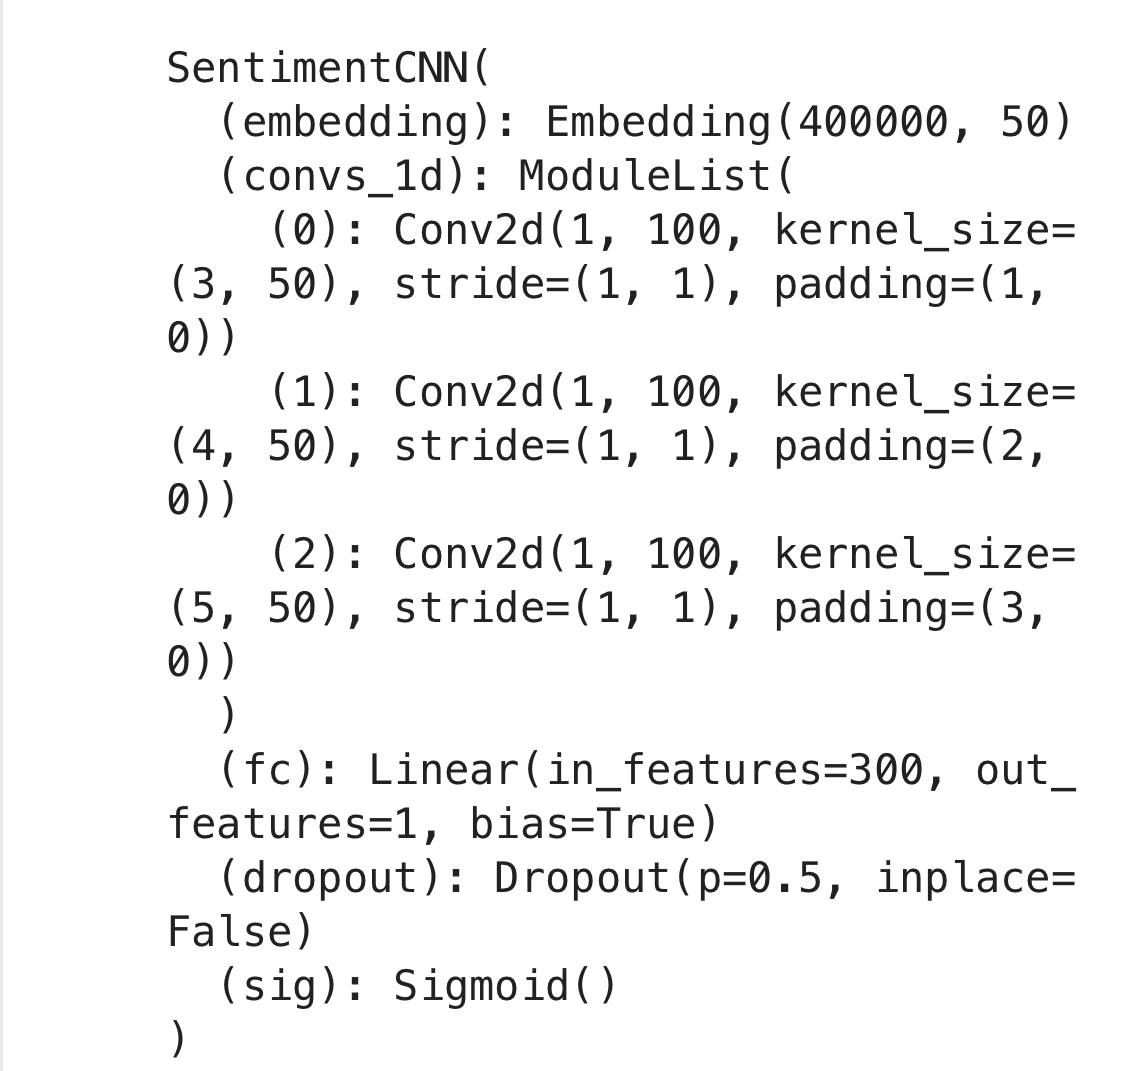

In [21]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [22]:
# training loop
def train(net, train_loader, val_loader, epochs, device):
    """
    Train the model on the train dataset and print the loss and accuracy plots.

    Parameters:
    - net: Trained model
    - train_loader: DataLoader for the train dataset
    - val_loader: DataLoader for the validate dataset
    - epochs : Number of epochs
    - device: Device to run the model on (CPU or GPU)
    """
    
    if torch.cuda.is_available():
        net = net.to(device)
    
    train_losses = []
    val_losses = []
    val_accuracies = []

    # train for some number of epochs
    for e in tqdm(range(epochs)):
        running_loss = 0.0
        net.train()

        # batch loop
        for inputs, labels in train_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)

            # zero accumulated gradients
            net.zero_grad()

            # get the output from the model
            output = net(inputs)
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # validation
        net.eval()
        val_losses_epoch = []
        num_correct = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                if torch.cuda.is_available():
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                # get predicted outputs
                val_output = net(val_inputs)

                # calculate loss
                val_loss = criterion(val_output.squeeze(), val_labels.float())
                val_losses_epoch.append(val_loss.item())

                # convert output probabilities to predicted class (0 or 1)
                pred = torch.round(val_output.squeeze())  # rounds to the nearest integer

                # compare predictions to true label
                correct_tensor = pred.eq(val_labels.float().view_as(pred))
                correct = np.squeeze(correct_tensor.cpu().numpy())
                num_correct += np.sum(correct)

        avg_val_loss = np.mean(val_losses_epoch)
        val_accuracy = num_correct / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Train Loss: {:.6f}...".format(avg_train_loss),
              "Validation Loss: {:.6f}...".format(avg_val_loss),
              "Validation Accuracy: {:.3f}".format(val_accuracy))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.show()


  3%|▎         | 1/30 [00:01<00:54,  1.87s/it]

Epoch: 1/30... Train Loss: 0.355597... Validation Loss: 0.207078... Validation Accuracy: 0.915


  7%|▋         | 2/30 [00:03<00:50,  1.80s/it]

Epoch: 2/30... Train Loss: 0.197084... Validation Loss: 0.129353... Validation Accuracy: 0.957


 10%|█         | 3/30 [00:05<00:47,  1.78s/it]

Epoch: 3/30... Train Loss: 0.130598... Validation Loss: 0.089990... Validation Accuracy: 0.971


 13%|█▎        | 4/30 [00:07<00:45,  1.77s/it]

Epoch: 4/30... Train Loss: 0.094901... Validation Loss: 0.075133... Validation Accuracy: 0.978


 17%|█▋        | 5/30 [00:08<00:44,  1.76s/it]

Epoch: 5/30... Train Loss: 0.068916... Validation Loss: 0.068750... Validation Accuracy: 0.978


 20%|██        | 6/30 [00:10<00:42,  1.76s/it]

Epoch: 6/30... Train Loss: 0.051694... Validation Loss: 0.071223... Validation Accuracy: 0.979


 23%|██▎       | 7/30 [00:12<00:40,  1.76s/it]

Epoch: 7/30... Train Loss: 0.041813... Validation Loss: 0.060758... Validation Accuracy: 0.981


 27%|██▋       | 8/30 [00:14<00:38,  1.76s/it]

Epoch: 8/30... Train Loss: 0.032868... Validation Loss: 0.062449... Validation Accuracy: 0.978


 30%|███       | 9/30 [00:15<00:37,  1.76s/it]

Epoch: 9/30... Train Loss: 0.025935... Validation Loss: 0.060961... Validation Accuracy: 0.980


 33%|███▎      | 10/30 [00:17<00:35,  1.76s/it]

Epoch: 10/30... Train Loss: 0.021768... Validation Loss: 0.067031... Validation Accuracy: 0.978


 37%|███▋      | 11/30 [00:19<00:33,  1.76s/it]

Epoch: 11/30... Train Loss: 0.020311... Validation Loss: 0.064196... Validation Accuracy: 0.978


 40%|████      | 12/30 [00:21<00:31,  1.76s/it]

Epoch: 12/30... Train Loss: 0.015640... Validation Loss: 0.069182... Validation Accuracy: 0.975


 43%|████▎     | 13/30 [00:22<00:29,  1.75s/it]

Epoch: 13/30... Train Loss: 0.012371... Validation Loss: 0.070532... Validation Accuracy: 0.978


 47%|████▋     | 14/30 [00:24<00:28,  1.75s/it]

Epoch: 14/30... Train Loss: 0.011113... Validation Loss: 0.070167... Validation Accuracy: 0.978


 50%|█████     | 15/30 [00:26<00:26,  1.75s/it]

Epoch: 15/30... Train Loss: 0.008967... Validation Loss: 0.075340... Validation Accuracy: 0.978


 53%|█████▎    | 16/30 [00:28<00:24,  1.75s/it]

Epoch: 16/30... Train Loss: 0.008816... Validation Loss: 0.074830... Validation Accuracy: 0.977


 57%|█████▋    | 17/30 [00:29<00:22,  1.75s/it]

Epoch: 17/30... Train Loss: 0.008708... Validation Loss: 0.076266... Validation Accuracy: 0.975


 60%|██████    | 18/30 [00:31<00:21,  1.75s/it]

Epoch: 18/30... Train Loss: 0.005842... Validation Loss: 0.075976... Validation Accuracy: 0.976


 63%|██████▎   | 19/30 [00:33<00:19,  1.75s/it]

Epoch: 19/30... Train Loss: 0.005363... Validation Loss: 0.089511... Validation Accuracy: 0.974


 67%|██████▋   | 20/30 [00:35<00:17,  1.75s/it]

Epoch: 20/30... Train Loss: 0.005285... Validation Loss: 0.078643... Validation Accuracy: 0.974


 70%|███████   | 21/30 [00:36<00:15,  1.75s/it]

Epoch: 21/30... Train Loss: 0.005425... Validation Loss: 0.084110... Validation Accuracy: 0.976


 73%|███████▎  | 22/30 [00:38<00:13,  1.75s/it]

Epoch: 22/30... Train Loss: 0.005752... Validation Loss: 0.084125... Validation Accuracy: 0.975


 77%|███████▋  | 23/30 [00:40<00:12,  1.75s/it]

Epoch: 23/30... Train Loss: 0.003838... Validation Loss: 0.086885... Validation Accuracy: 0.975


 80%|████████  | 24/30 [00:42<00:10,  1.75s/it]

Epoch: 24/30... Train Loss: 0.004881... Validation Loss: 0.087488... Validation Accuracy: 0.975


 83%|████████▎ | 25/30 [00:43<00:08,  1.75s/it]

Epoch: 25/30... Train Loss: 0.003252... Validation Loss: 0.089381... Validation Accuracy: 0.975


 87%|████████▋ | 26/30 [00:45<00:07,  1.75s/it]

Epoch: 26/30... Train Loss: 0.003391... Validation Loss: 0.100946... Validation Accuracy: 0.974


 90%|█████████ | 27/30 [00:47<00:05,  1.75s/it]

Epoch: 27/30... Train Loss: 0.006343... Validation Loss: 0.104232... Validation Accuracy: 0.974


 93%|█████████▎| 28/30 [00:49<00:03,  1.76s/it]

Epoch: 28/30... Train Loss: 0.004118... Validation Loss: 0.100080... Validation Accuracy: 0.972


 97%|█████████▋| 29/30 [00:50<00:01,  1.76s/it]

Epoch: 29/30... Train Loss: 0.004068... Validation Loss: 0.098986... Validation Accuracy: 0.973


100%|██████████| 30/30 [00:52<00:00,  1.76s/it]

Epoch: 30/30... Train Loss: 0.002572... Validation Loss: 0.100110... Validation Accuracy: 0.974


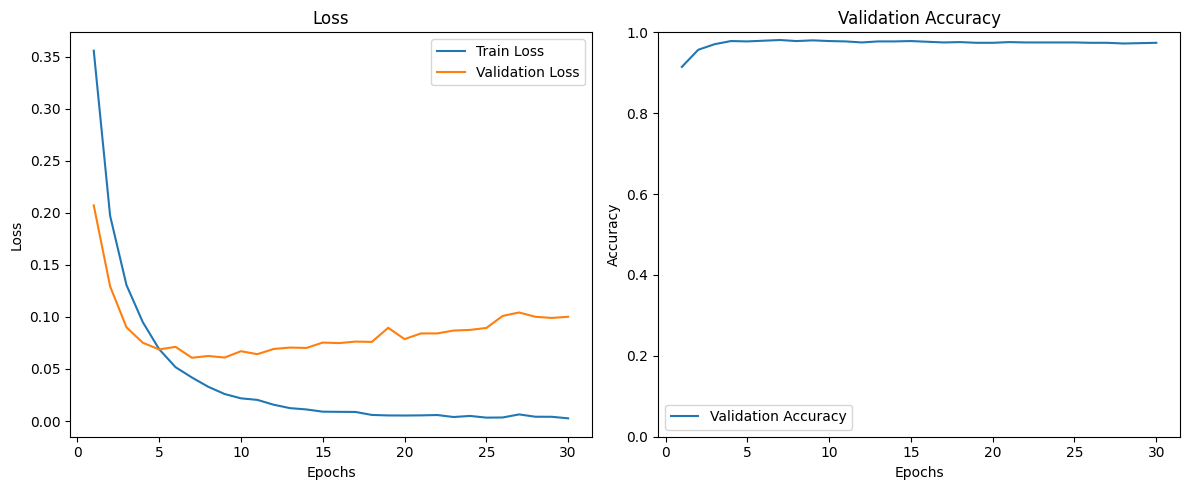

In [23]:
# training params
epochs = 30
train(net, train_dataloader, val_dataloader, epochs, device)

In [26]:
def evaluate(net, test_loader, device):
    """
    Evaluate the model on the test dataset and print the loss, accuracy, and confusion matrix.

    Parameters:
    - net: Trained model
    - test_loader: DataLoader for the test dataset
    - device: Device to run the model on (CPU or GPU)
    """
    net.eval()
    
    test_losses = []  # track loss
    num_correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        # iterate over test data
        for inputs, labels in test_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
            
            # get predicted outputs
            output = net(inputs)
            
            # calculate loss
            test_loss = criterion(output.squeeze(), labels.float())
            test_losses.append(test_loss.item())
            
            # convert output probabilities to predicted class (0 or 1)
            pred = torch.round(output.squeeze())  # rounds to the nearest integer
            
            # compare predictions to true label
            correct_tensor = pred.eq(labels.float().view_as(pred))
            correct = np.squeeze(correct_tensor.cpu().numpy())
            num_correct += np.sum(correct)

            # Save predictions and labels for confusion matrix
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # -- stats -- ##
    # avg test loss
    print("Test loss: {:.3f}".format(np.mean(test_losses)))

    # accuracy over all test data
    test_acc = num_correct / len(test_loader.dataset)
    print("Test accuracy: {:.3f}".format(test_acc))

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Test loss: 0.089
Test accuracy: 0.974


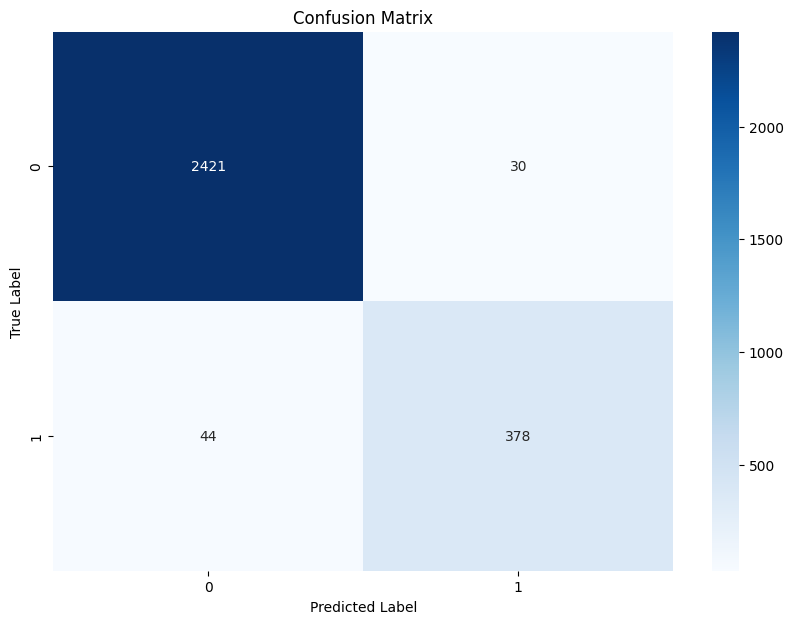

In [27]:
evaluate(net, test_dataloader, device)